In [1]:
## anaconda3 (Python 3.12.0) Kernel
# pair trade packages
import csv
import gym
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
# nn packages
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler

def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')
# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)
# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_56118/1916853760.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


# Load Pairs Data


# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [2]:
with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    # Skip the header row
    next(reader)
    working_pairs = [tuple(row) for row in reader]

top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]
print("Top 10 clustered trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Return: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")

Top 10 clustered trades:
1. Key: 6503 JP Equity 7269 JP Equity, Return: 1.33
2. Key: 6326 JP Equity 6954 JP Equity, Return: 1.19
3. Key: 8053 JP Equity 8058 JP Equity, Return: 0.52
4. Key: 4901 JP Equity 9613 JP Equity, Return: 1.10
5. Key: 6988 JP Equity 7267 JP Equity, Return: 0.65
6. Key: 4901 JP Equity 6702 JP Equity, Return: -0.34
7. Key: 4684 JP Equity 7832 JP Equity, Return: 0.89
8. Key: 7267 JP Equity 8306 JP Equity, Return: 1.16
9. Key: 7267 JP Equity 8801 JP Equity, Return: 0.64
10. Key: 4519 JP Equity 7532 JP Equity, Return: 1.14


In [3]:
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]

# due to spikey-ness of reward around 0, scale from -1 to 1 and give more rewards above 1, 2, 3
dailypnl_sd = 0.018390515013803736 
# see /Users/ju/Projects/00_SMU/mqf_practice/QF634_Applied_Quantitative_Research_Methods/QF634 Project/Pair Trading/03_project_state_space_analysis.ipynb for SD derivation

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_56118/2914914838.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


table is taking a long time to generalise. using one pair is not good enough to get any poistioning as everything is flat. only after adding all 10 pairs then performance churns out shorting on 1 SD high cross.

Experiment: try making gamma 0.1, Q table should closely mimic the state space analysis table with strong mean reversion tendency. This is not what we see. and it even has Q values opposite to state space.

In [4]:
rollingWindow = 262
cutLossSd = 2

for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[pair].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()

workingPairOutcome[top_keys[5]][-5:]  

array([[2.00028887, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.6859092 , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.52197973, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.40723813, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ],
       [2.46852476, 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        ]])

- Test one timestep at a time (even though we can test all at the same time)
- give state
- Trading should be path dependent due to stop loss. in this case I can only give last position as one of the parameters

In [5]:
class PairTradeEnv(gym.Env):
    # ... (define your environment's state space, action space, etc.)
    def __init__(self, workingPairOutcome, top_keys, validPairsList, return_df):
        # ... (initialize other parameters)
        self.earliest_step = 261
        self.last_step = 2868
        self.current_step = self.earliest_step


    def step(self, action, pair_idx):
        """
        Input
            action: single value e.g. -1 (short)
            pair_idx: index of pair trade
        Output:
            next_state: next state 
            reward: reward for last timestep
            done: boolean for if end of dataset
            info: optional
        """
        self.current_step += 1
        next_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        reward = self.calculate_reward(action, self.current_step, validPairsList[pair_idx])
        done = self.current_step >= self.last_step

        info = {}

        return next_state, reward, done, info

    def reset(self, pair_idx):
        self.current_step = self.earliest_step
        initial_state = workingPairOutcome[top_keys[pair_idx]][self.current_step]
        return initial_state
    
    def calculate_reward(self, position, idx, pair):
        """
        Give one _previous_ day's return
        Input:
            position: position for idx (current step)
            idx: usually current timestp 
            pair: tuple of tpx stock
        Output:
            dailypnl
        """
        position_0 = position
        position_1 = position * -1
        dailypnl = position_0*return_df[f'{pair[0]}'].iloc[idx] + position_1*return_df[f'{pair[1]}'].iloc[idx] 

        return dailypnl

In [6]:
def compute_priorities(replay_buffer, alpha=0.6):
    """
    Compute priorities for sampling based on temporal difference (TD) error or recency.
    """
    priorities = []
    for experience in replay_buffer:
        _, _, reward, _, _ = experience
        td_error = abs(reward)  # Simplified proxy for TD error
        priority = (td_error + 1e-5) ** alpha
        priorities.append(priority)
    return priorities

def evaluate_agent_train(agent, env, number_of_pairs):
    """
    Evaluates the agent's train performance over one episode without epsilon exploration.
    """
    total_rewards = np.zeros(number_of_pairs)

    for pair_idx in range(number_of_pairs):
        state = env.reset(pair_idx)
        env.current_step = 261
        env.last_step = 2978
        pair_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                q_values = agent.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()
                action = agent.index_to_action[action_index]
            
            # Take the selected action
            next_state, reward, done, _ = env.step(action, pair_idx)
            pair_reward += reward
            state = next_state

        total_rewards[pair_idx] = pair_reward

    # Return the average reward across all pairs
    return total_rewards.mean()

def evaluate_agent_test(agent, env, number_of_pairs):
    """
    Evaluates the agent's test performance over one episode without epsilon exploration.
    """
    total_rewards = np.zeros(number_of_pairs)

    for pair_idx in range(number_of_pairs):
        state = env.reset(pair_idx)
        env.current_step = 2868
        env.last_step = 2978
        pair_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                # Select action based purely on Q-network (greedy action)
                q_values = agent.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()
                action = agent.index_to_action[action_index]
            
            # Take the selected action
            next_state, reward, done, _ = env.step(action, pair_idx)
            pair_reward += reward
            state = next_state

        total_rewards[pair_idx] = pair_reward

    # Return the average reward across all pairs
    return total_rewards.mean()

class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.2):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        # self.dropout1 = nn.Dropout(p=dropout_rate) 
        self.fc2 = nn.Linear(8, 8)
        # self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(8, output_size)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        # x = self.dropout1(x)
        x = self.leaky_relu(self.fc2(x))
        # x = self.dropout2(x)
        x = self.fc3(x)
        return x


class QLearningAgent:
    def __init__(self, input_size, output_size, learning_rate, discount_factor, epsilon, epsilon_decay, batch_size=1000, replay_buffer_size=10000):
        self.q_network = QNetwork(input_size, output_size)
        self.target_network = QNetwork(input_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate) 
        self.loss_fn = nn.MSELoss()
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learn_count = 0
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.replay_buffer_size = replay_buffer_size
        
        # Action to index mapping
        self.action_to_index = {-1: 0, 0: 1, 1: 2}
        self.index_to_action = {0: -1, 1: 0, 2: 1}

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice([-1, 0, 1])  # Explore
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                action_index = torch.argmax(q_values, dim=1).item()  # Choose best action
            action = self.index_to_action[action_index] 
        return action

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def learn(self):
        if len(self.replay_buffer) < self.replay_buffer_size:
            return

        # Compute priorities for sampling and sampler
        priorities = compute_priorities(self.replay_buffer)
        weights = np.array(priorities) / sum(priorities)
        sampler = WeightedRandomSampler(weights, self.batch_size, replacement=True)
        # dataloader = DataLoader(list(self.replay_buffer), batch_size=self.batch_size, sampler=sampler)
        dataloader = DataLoader(list(self.replay_buffer), batch_size=self.batch_size, shuffle=True)

        # batch_count = 0
        # if batch_count >=1:
        #     break
        states, actions, rewards, next_states, dones = next(iter(dataloader))
        states = states.clone().detach().float()
        next_states = next_states.clone().detach().float()
        actions = torch.tensor([self.action_to_index[action.item()] for action in actions]).view(-1, 1)
        rewards = rewards.clone().detach().float().view(-1, 1)
        q_values = self.q_network(states).gather(1, actions)
        dones = dones.float()

        next_q_values = self.target_network(next_states).max(1, keepdim=True)[0].detach().view(-1, 1)
        target_q_values = rewards + self.discount_factor * next_q_values * (1 - dones).view(-1,1)

        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        if self.learn_count%200000==0:
            for name, param in agent.q_network.named_parameters():
                if 'fc2.weight' in name and param.requires_grad:
                    print(f"{name} grad: {param.grad}")
        self.optimizer.step()

        self.learn_count += 1
        # Update target network every few episodes
        if self.learn_count % 5 == 0:
            self.update_target_network()

        # batch_count += 1
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())



# Run experiment

fc2.weight grad: tensor([[-3.8743e-03, -7.1230e-04, -4.3414e-03, -3.0667e-03, -4.0062e-03,
         -2.4171e-03, -1.8466e-03, -6.3957e-04],
        [ 1.5062e-02,  4.0870e-03,  1.3433e-02,  1.5573e-02,  1.1989e-02,
          1.1619e-02,  1.1425e-02,  1.7977e-03],
        [-7.3162e-05, -1.1791e-05, -7.6810e-05, -1.0158e-04, -7.7617e-05,
         -7.7995e-05, -5.0889e-05, -1.3163e-05],
        [-1.2299e-03, -4.0544e-04, -1.1680e-03, -1.5809e-04, -8.5322e-04,
         -1.1425e-04, -5.8313e-04, -1.0340e-04],
        [ 4.4418e-03,  2.1376e-03,  1.1573e-03,  3.0176e-05,  3.0563e-05,
         -3.5802e-06,  4.6630e-03, -1.7732e-05],
        [ 2.6494e-02,  6.4775e-03,  2.5051e-02,  2.7646e-02,  2.2908e-02,
          2.0858e-02,  1.8788e-02,  3.5442e-03],
        [ 2.8913e-03,  1.8819e-03,  1.4283e-02,  2.3712e-02,  1.2522e-02,
          1.7575e-02,  2.8715e-03,  1.4086e-03],
        [ 2.6971e-03,  8.7068e-04,  2.6786e-03, -5.5832e-05,  1.9397e-03,
         -3.6468e-05,  1.0639e-03,  2.3477e-04]]

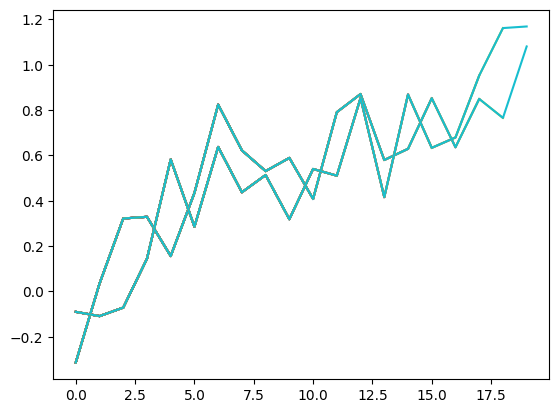

In [11]:
# learning_rate = 0.1
# ls_lr = [.02, .03, .05]
learning_rate = 0.02
discount_factor = 0.1
epsilon = 1.0
epsilon_decay = 0.88

## Training constants
total_episodes = 20
total_epoch = 2
number_of_pairs = len(workingPairOutcome)
ls_epo_train_reward = []
ls_epo_test_reward = []

for epoch in range(total_epoch):
    env = PairTradeEnv(workingPairOutcome, top_keys, validPairsList, return_df)
    agent = QLearningAgent(input_size=7, 
                           output_size=3, 
                           learning_rate=learning_rate, 
                           discount_factor=discount_factor, 
                           epsilon=1.0, 
                           epsilon_decay=0.88, 
                           batch_size=len(top_keys)*100, 
                           replay_buffer_size=10000)

    ls_epi_reward = []
    for episode in range(total_episodes):
        arr_pair_reward = np.zeros(number_of_pairs)

        for pair_idx in range(number_of_pairs):
            state = env.reset(pair_idx)
            pair_reward = 0
            done = False
            
            while not done:
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action, pair_idx)
                pair_reward += reward
                reward /= dailypnl_sd

                agent.store_experience(state, action, reward, next_state, done)
                agent.learn()
                
                state = next_state

            arr_pair_reward[pair_idx] = pair_reward
        
        total_reward = arr_pair_reward.mean()
        print(f"Episode {episode+1}: Total Return: {total_reward:.3f}, Epsilon: {agent.epsilon:.2f}")
        ls_epi_reward.append(total_reward)

        agent.epsilon = max(0.3, agent.epsilon * agent.epsilon_decay)

        plt.plot(ls_epi_reward)

    agent.q_network.eval()
    agent.target_network.eval()

    ls_epo_train_reward.append(evaluate_agent_train(agent, env, number_of_pairs))
    ls_epo_test_reward.append(evaluate_agent_test(agent, env, number_of_pairs))

In [12]:
ls_print = [
    learning_rate,
    discount_factor,
    epsilon,
    epsilon_decay,
    total_epoch,
    total_episodes
    ]
for i, p in enumerate(ls_print):
    print(f"{p}")
print(f"Evaluation: Average Total Train Return:{ls_epo_train_reward}")
print(f"Evaluation: Average Total Train Return: mean {np.array(ls_epo_train_reward).mean():.4f}, SD {np.array(ls_epo_train_reward).std():.4f}")
print(f"Evaluation: Average Total Test Return: {ls_epo_test_reward}")
print(f"Evaluation: Average Total Test Return: mean {np.array(ls_epo_test_reward).mean():.4f}, SD {np.array(ls_epo_test_reward).std():.4f}")

0.02
0.1
1.0
0.88
2
20
Evaluation: Average Total Train Return:[1.4159413632232236, 1.7217484023299363]
Evaluation: Average Total Train Return: mean 1.5688, SD 0.1529
Evaluation: Average Total Test Return: [0.13567961476446935, 0.162100439486682]
Evaluation: Average Total Test Return: mean 0.1489, SD 0.0132


In [17]:
# Assuming states is a list of 6 states, each a list or NumPy array
states = [[-0.5, 0, 0, 0, 1, 0, 0],
        [-1.5, 0, 0, 0, 1, 1, 0],
        [-2.5, 0, 0, 0, 1, 1, 1],
        [0.5, 0, 0, 1, 0, 0, 0],
        [1.5, 1, 1, 1, 0, 0, 0],
        [2.5, 1, 1, 1, 0, 0, 0]]

# Convert to PyTorch tensor (ensure float32 for compatibility)
states_tensor = torch.tensor(states, dtype=torch.float32)

# Evaluate the Q-values for all states
agent.q_network.eval()  # Set the network to evaluation mode
with torch.no_grad():
    q_values = agent.q_network(states_tensor)  # Output will be a tensor of shape (, output_size)

# Example: Get the greedy actions for each state
action_indices = torch.argmax(q_values, dim=1).tolist()
actions = [agent.index_to_action[index] for index in action_indices]

print("Q-values:", q_values)
print("Greedy actions:", actions)


Q-values: tensor([[ 9.1646e-03,  6.5699e-03,  4.4713e-02],
        [-5.4129e-02,  8.3101e-03,  6.2126e-02],
        [-1.9067e-01,  1.3419e-02,  1.1637e-01],
        [ 2.3418e-02,  4.1083e-03, -3.4427e-02],
        [ 8.5561e+01, -8.3283e+00, -5.9685e+01],
        [ 1.4495e-01,  1.1330e-02, -1.9952e-01]])
Greedy actions: [1, 1, 1, -1, -1, -1]


In [13]:
# After training, save the entire Q-network
torch.save(agent.q_network, f"q_network_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth")

In [15]:
dict_policy_actions = dict(zip([tuple(state) for state in states], actions))
dict_policy_actions[(0, 0, 0, 0, 0, 0, 0)] = 0
dict_policy_actions

{(-0.5, 0, 0, 0, 1, 0, 0): 1,
 (-1.5, 0, 0, 0, 1, 1, 0): 1,
 (-2.5, 0, 0, 0, 1, 1, 1): 1,
 (0.5, 0, 0, 1, 0, 0, 0): -1,
 (1.5, 1, 1, 1, 0, 0, 0): -1,
 (2.5, 1, 1, 1, 0, 0, 0): -1,
 (0, 0, 0, 0, 0, 0, 0): 0}

# Saved Results
## DQN


==================== Baseline Return Train ====================
Mean: 			1.55965
Mean (ave daily return): 0.00060
==================== Baseline Return Test ====================
Mean: 			0.16210
Mean (ave daily return): 0.00146


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_56118/3422814084.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_q_network = torch.load("25_q_network_2

<Axes: xlabel='Date'>

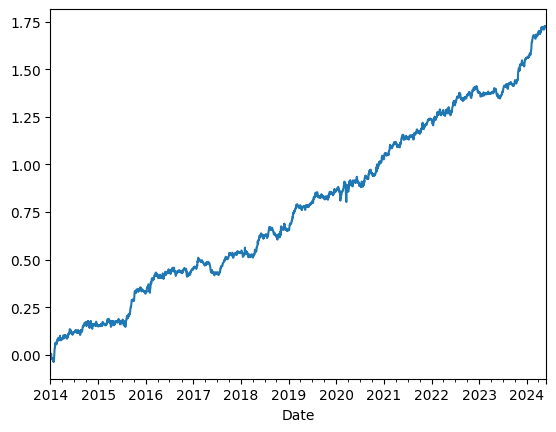

In [16]:
loaded_q_network = torch.load("25_q_network_20241215_212619.pth")
loaded_q_network.eval()

result_dict = {}

for key, pair in zip(top_keys, validPairsList):
    result_dict[key] = {}
    result_dict[key]['state'] = workingPairOutcome[key]

    t_array = torch.tensor(workingPairOutcome[key], dtype=torch.float32)
    with torch.no_grad():
        q_values = loaded_q_network(t_array)
    index_to_action = {0: -1, 1: 0, 2: 1}
    action_indices = torch.argmax(q_values, dim=1).tolist()
    actions = [index_to_action[index] for index in action_indices]
    actions[:261] = [0] * 261
    result_dict[key]['action'] = actions

    dummy_df = pairsOutcome[key]
    dummy_df['position'] = result_dict[key]['action']
    dummy_df[f"{pair[0]} position"] = dummy_df['position']
    dummy_df[f"{pair[1]} position"] = dummy_df['position'] * -1

    dummy_df['dailypnl'] = dummy_df[f'{pair[0]} position'].values*return_df[f'{pair[0]}'].shift(-1).values  + dummy_df[f'{pair[1]} position'].values*return_df[f'{pair[1]}'].shift(-1).values
    dummy_df['cumpnl'] = dummy_df['dailypnl'].cumsum()
    pairsOutcome[key] = dummy_df

# combine daily returns from all pair trades
dailypnl_data = [pairsOutcome[key]['dailypnl'] for key in top_keys]
df_daily_returns =  pd.DataFrame(dailypnl_data).T # Transpose to align rows
# obtain train and test returns
baseline_train_mean_return = df_daily_returns.iloc[:2868].cumsum().mean(axis=1)[-1]
baseline_test_mean_return = df_daily_returns.iloc[2869:].cumsum().iloc[-2].mean()
print("="*20, "Baseline Return Train","="*20)
print(f"Mean: \t\t\t{baseline_train_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_train_mean_return/(2868-261):.5f}")
print("="*20, "Baseline Return Test","="*20)
print(f"Mean: \t\t\t{baseline_test_mean_return:.5f}")
print(f"Mean (ave daily return): {baseline_test_mean_return/(2979-2868):.5f}")
# print baseline restults to csv
df_export = df_daily_returns.mean(axis=1).cumsum()[261:]
df_export.to_csv("35_DQN_return.csv")
df_export.plot()

### 15 Dec
- lr = 0.01, discount factor 0.99. 10 episodes X 3 had good performance but slow. there was upward slope up to 0.6 total rewards.
- rerun with learning rate at 0.1. also decreased discount factor to match Q table params. might find out that results are bad when we increase lr too fast. can try something in the middel like .05. Some learning but not as clean as 0.01. going to do grid search for .02 to .05, 10 episodes each

    `0.1
    1.0
    0.88
    3
    10
    Evaluation: Average Total Train Return:[1.5686587630554472, 1.334381824485434, 0.3910475469273056]
    Evaluation: Average Total Train Return: mean 1.0980, SD 0.5090
    Evaluation: Average Total Test Return: [0.1360401584920572, 0.06058529518087073, 0.02115436661176917]
    Evaluation: Average Total Test Return: mean 0.0726, SD 0.0477`
    - .02 seems to be the most consistent. but the growth in performance looks the same